# BigEarthNet v2.0 / {{reben}}
This page describes the usage of Dataloader and Datamodule for {{reben}} (also known as reBEN or BigEarthNet v2.0), a multi-spectral multilabel Remote Sensing Land-Use/Land-Cover classification dataset.

The official paper of the {{reben}} dataset was initially published in {cite:t}`reBEN`.

For detailed information on the dataset itself please refer to the publications.

In [23]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch
from configilm.extra import data_dir

my_data_path = data_dir.mock_data_path["benv2"]

The dataset is divided into two modules which contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. The `Dataset` uses a `BENv2LMDBReader` to read images and labels from a LMDB file. Labels are returned in their 19-label version as one-hot vector.

## BENv2DataSet

In its most basic form, the `Dataset` only needs the base path of the LMDB file and metadata parquet files. Note, that from an os point of view, LMDB files are folders. This `Dataset` will load 3 channels (10m RGB Sentinel-2).

The full data path structure expected is
```
datapath = {
    "images_lmdb": "/path/to/BigEarthNetEncoded.lmdb",
    "metadata_parquet": "/path/to/metadata.parquet",
    "metadata_snow_cloud_parquet": "/path/to/metadata_snow_cloud.parquet",
}
```
Note, that the keys have to match exactly while the paths can be selected freely.

In [24]:
from configilm import util
util.MESSAGE_LEVEL = util.MessageLevel.INFO  # use INFO to see all messages

from configilm.extra.DataSets import BENv2_DataSet
from configilm.extra.DataModules import BENv2_DataModule


ds = BENv2_DataSet.BENv2DataSet(
    data_dirs=my_data_path  # path set by to dataset
)

img, lbl = ds[0]
img = img # only choose RGB channels

[INFO]    Loading BEN data for None...
[INFO]        18 patches indexed
[INFO]        18 pre-filtered patches indexed
[INFO]        18 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created
[INFO]    Opening LMDB environment ...


Size: torch.Size([3, 120, 120])
Labels:
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0.], dtype=torch.float64)


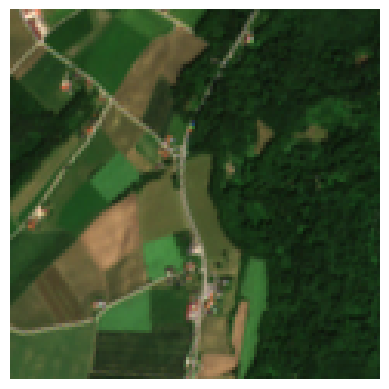

In [25]:
# remove-input
print(f"Size: {img.shape}")
print("Labels:")
pprint(lbl)
# images are 12 bit of radiometric resolution, so to display simply divide by the largest value
# this will not be the best way of displaying but enough as a showcase
img /= max(img.clone().flatten())
# and make it HWC instead of CHW())
img = img.permute(1, 2, 0)
_ = plt.imshow(img)
plt.axis('off')
plt.show()

### Selecting Bands

The `Dataset` also supports different channel configurations, however, setting the selected channels is only supported via image size selection and only limited combinations are available. To see the available combinations call `BENv2_DataSet.BENv2DataSet.get_available_channel_configurations()`. Alternatively, a faulty configuration will display the possibilities as well whilst raising an `AssertionError`.

The configurations are working like setting the respective number as `bands` parameter in the `LMDBReader`.

In [26]:
BENv2_DataSet.BENv2DataSet.get_available_channel_configurations()

[HINT]    Available channel configurations are:
[HINT]          2 -> Sentinel-1
[HINT]          3 -> RGB
[HINT]          4 -> 10m Sentinel-2
[HINT]         10 -> 10m + 20m Sentinel-2
[HINT]         12 -> 10m + 20m Sentinel-2 + 10m Sentinel-1
[HINT]         14 -> 10m + 20m Sentinel-2 + 60m Sentinel-2 + 10m Sentinel-1 


### Splits

It is possible to load only a specific split (`'train'`, `'val'` or `'test'`) in the dataset. The images loaded are specified using the parquet files in the `data_dir` parameter. By default (`None`), all three splits are loaded into the same `Dataset`.

In [27]:
_ = BENv2_DataSet.BENv2DataSet(
    data_dirs=my_data_path,  # path set by to dataset
    split="train"
)

[INFO]    Loading BEN data for train...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created


### Restricting the number of loaded images

It is also possible to restrict the number of images indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their S2-name) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the parquet file(s) (in this case 6) equals to load-all-images behaviour.

In [28]:
_ = BENv2_DataSet.BENv2DataSet(
    data_dirs=my_data_path,  # path set by to dataset
    split="train",
    max_len=5
)

[INFO]    Loading BEN data for train...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        5 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created


In [29]:
_ = BENv2_DataSet.BENv2DataSet(
    data_dirs=my_data_path,  # path set by to dataset
    split="train",
    max_len=100
)

[INFO]    Loading BEN data for train...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created


## BENv2DataModule

This class is a [Lightning Data Module](https://pytorch-lightning.readthedocs.io/en/stable/data/datamodule.html), that wraps the `BENv2DataSet`. It automatically generates `DataLoader` per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).

To use a `DataModule`, the `setup()` function has to be called. This populates the `Dataset` splits inside the `DataModule`. Depending on the stage (`'fit'`, `'test'` or `None`), the setup will prepare only train & validation `Dataset`, only test `Dataset` or all three.

In [30]:
dm = BENv2_DataModule.BENv2DataModule(
    data_dirs=my_data_path  # path set by to dataset
)
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

print("\n=== SETUP ===")
dm.setup(stage="fit")
print("=== END SETUP ===\n")
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

[WARNING] Using default train transform.
[WARNING] Using default eval transform.
Before:
None
None
None

=== SETUP ===
[INFO]    Loading BEN data for train...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created
[INFO]    Loading BEN data for validation...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created
[INFO]      Total training samples:        6  Total validation samples:        6
=== END SETUP ===

After:
None


Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 6/16 -> 1.

In [31]:
train_loader = dm.train_dataloader()
print(len(train_loader))

1


The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have three settable parameters: `batch_size`, `num_workers_dataloader` and `shuffle` with 16, `os.cpu_count()` / 2 and `None` as their default values. A shuffle of `None` means, that the train set is shuffled but validation and test are not. Changing this setting will be accompanied by a Message-Hint printed.

Not changeable is the usage of pinned memory, which is set to `True` if a cuda-enabled device is found and `False` otherwise.

In [32]:
dm = BENv2_DataModule.BENv2DataModule(
    data_dirs=my_data_path,  # path set by to dataset
    batch_size=4
)
print("\n=== SETUP ===")
dm.setup(stage="fit")
print("=== END SETUP ===\n")
print(len(dm.train_dataloader()))

[WARNING] Using default train transform.
[WARNING] Using default eval transform.

=== SETUP ===
[INFO]    Loading BEN data for train...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created
[INFO]    Loading BEN data for validation...
[INFO]        6 patches indexed
[INFO]        6 pre-filtered patches indexed
[INFO]        6 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 24 labels
[INFO]    Loaded 24 keys
[INFO]    Loaded mapping created
[INFO]      Total training samples:        6  Total validation samples:        6
=== END SETUP ===

2


In [33]:
_ = BENv2_DataModule.BENv2DataModule(
    data_dirs=my_data_path,  # path set by to dataset
    shuffle=False
)

[WARNING] Shuffle was set to False. This is not recommended for most configuration. Use shuffle=None (default) for recommended configuration.
[WARNING] Using default train transform.
[WARNING] Using default eval transform.


In [34]:
_ = BENv2_DataModule.BENv2DataModule(
    data_dirs=my_data_path,  # path set by to dataset
    num_workers_dataloader=2
)

[WARNING] Using default train transform.
[WARNING] Using default eval transform.
